## Credit Card Fraud Detection
### Support-Vector Machines (SVM)

<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Credit-cards.jpg/220px-Credit-cards.jpg"/>

### Table of Contents

1. [Exploratory Analysis](#exploratory-analysis) <br>
2. [Split the data for training](#split) <br>
3. [Implementation](#implementation) <br>
3.1 [Loss function](#loss_fn) <br>
3.2 [Forward function](#forward_fn) <br>
3.3 [SVM function](#svm_fn) <br>
3.4 [Optimize function](#optimize_fn) <br>
3.5 [Training function](#training_fn) <br>
4. [Results analysis](#results) <br>
5. [Conclusion](#conclusion)

<a id="exploratory-analysis"></a>
# Exploratory Analysis

To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data. Depending on the data, not all plots will be made. (Hey, I'm just a kerneling bot, not a Kaggle Competitions Grandmaster!)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

There is 1 csv file in the current version of the dataset:


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = math.ceil(nCol / nGraphPerRow)  # Calculate the number of rows as an integer
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

# Example usage
# plotPerColumnDistribution(df1, 10, 5)


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

#### Let's check 1st file: /kaggle/input/creditcard.csv

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# creditcard.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('//content/creditcard.csv.zip', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'creditcard.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 31 columns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's take a quick look at what the data looks like:

In [ ]:
df1.head(5)

Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

Distribution graphs (histogram/bar graph) of sampled columns:

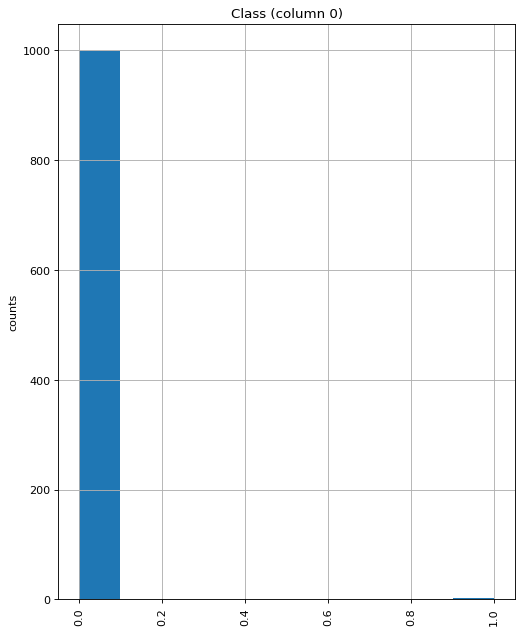

In [ ]:
plotPerColumnDistribution(df1, 10, 5)

Correlation matrix:

<ipython-input-76-a0343c621274>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


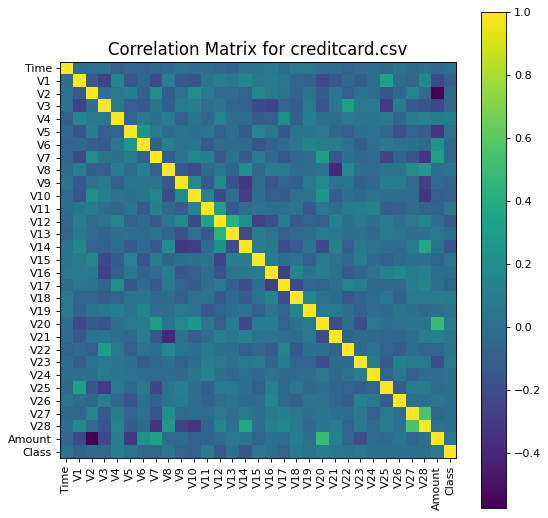

In [ ]:
plotCorrelationMatrix(df1, 8)

Scatter and density plots:

<ipython-input-77-45d7bdcfca59>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


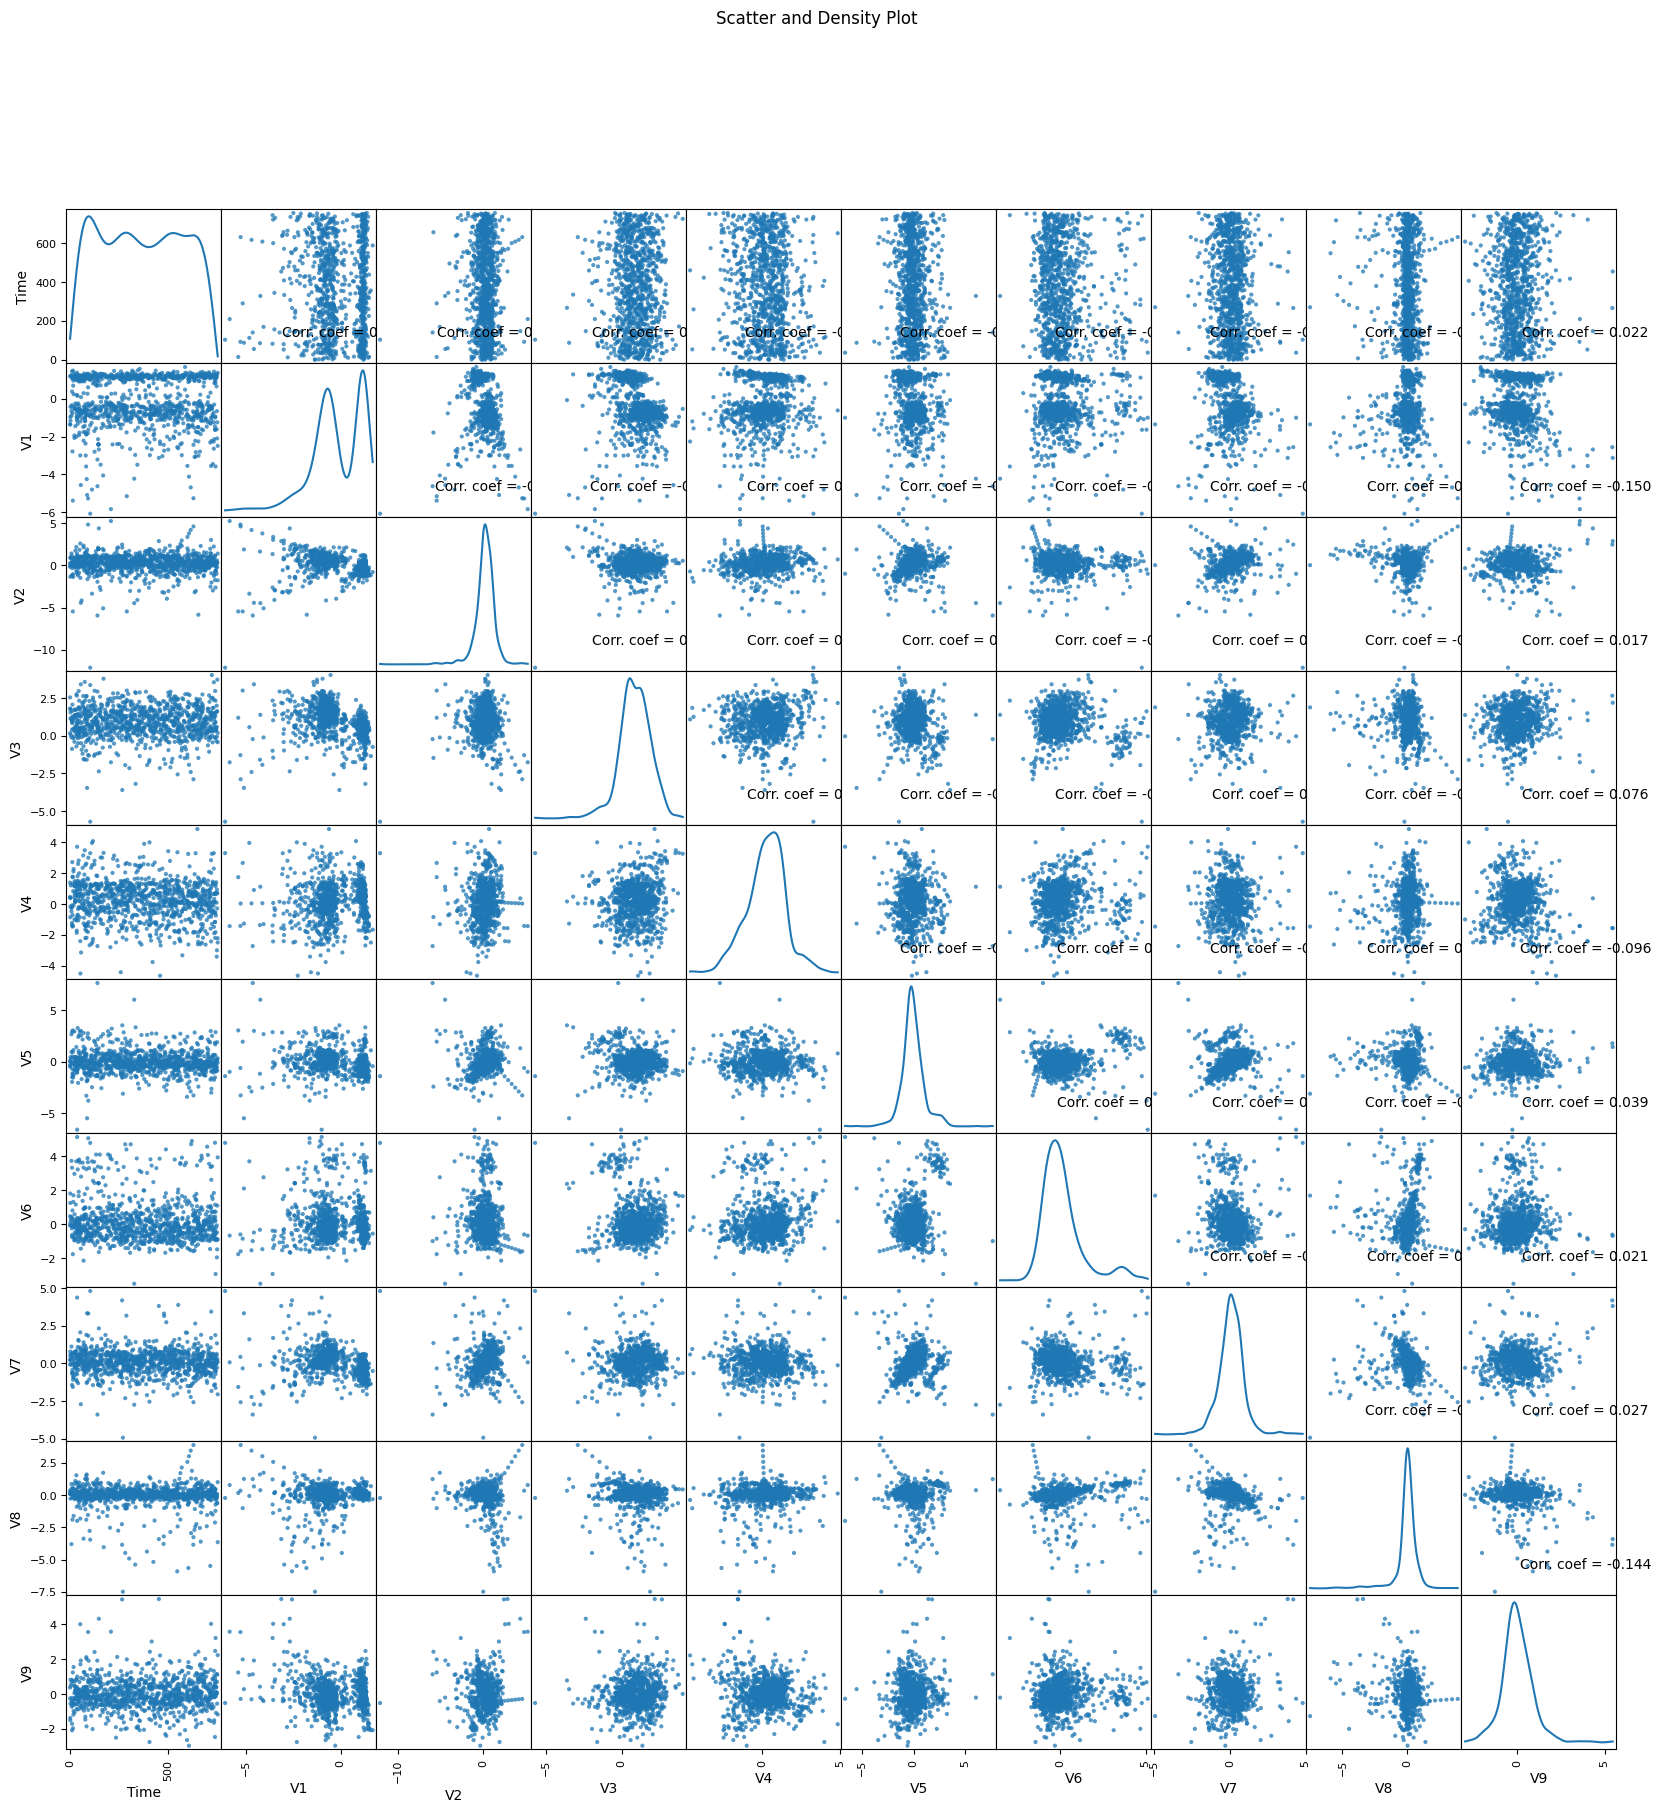

In [ ]:
plotScatterMatrix(df1, 20, 10)

In [ ]:
df1.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

<a id="split"></a>
### Split the data for training

In [ ]:
y = df1['Class']

In [ ]:
x = df1.drop(columns=['Time', 'Amount'])

In [ ]:
x = x.to_numpy()
y = y.to_numpy()

In [ ]:
y[np.where(y == 0)] = -1

In [ ]:
w = np.ones(len(x[0]))

<a id="definition"></a>
### Definition

<img align="left" style="padding: 50px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png">

<p style="padding: 10px"> In machine learning, support-vector machines (SVMs, also support-vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting) </p>

[https://en.wikipedia.org/wiki/Support_vector_machine](https://en.wikipedia.org/wiki/Support_vector_machine)

<a id="implementation"></a>
# Implementation

<a id="loss_fn"></a>
#### Loss function

In [ ]:
def hinge_loss_fn(y, y_hat):
    return np.maximum(0,(np.ones(len(y)) - y * y_hat))

<a id="forward_fn"></a>
#### Forward function

In [ ]:
def forward(x, w):
    return np.dot(x, w)

<a id="svm_fn"></a>
#### SVM function

In [ ]:
def svm_fn(x, y, w, epoch):
    if (y * forward(x, w)) < 1:
        return ( (x * y) + (-2  * (1/epoch) * w) )
    else:
        return (-2 * (1/epoch) * w)

<a id="optimize_fn"></a>
#### Optimize function (SGD)

In [ ]:
def optimize(w, dw, lr):
    w += lr * dw
    return w

<a id="training_fn"></a>
#### Training function

In [ ]:
def svm(x, y, w, epochs=1601, lr=0.001):

    losses = []

    for epoch in range(1,epochs):
        for i, _ in enumerate(x):
            dw = svm_fn(x[i], y[i], w, epoch)
            w = optimize(w, dw, lr)

        if(epoch % 100 == 0):
            loss = hinge_loss_fn(y, np.dot(x, w)).mean()
            losses.append(loss)
            print("Epoch ", epoch, " - Hinge Loss ", loss)

    return w, losses

In [ ]:
w = np.zeros(len(x[0]))

In [ ]:
w, losses = svm(x, y, w)

Epoch  100  - Hinge Loss  0.05758884638761123
Epoch  200  - Hinge Loss  0.024845814571034935
Epoch  300  - Hinge Loss  0.010898763170084882
Epoch  400  - Hinge Loss  0.004621643853664255
Epoch  500  - Hinge Loss  0.0036629652390496206
Epoch  600  - Hinge Loss  0.0035280934204681507
Epoch  700  - Hinge Loss  0.00322704244956852
Epoch  800  - Hinge Loss  0.003243989260841947
Epoch  900  - Hinge Loss  0.0030156776526624176
Epoch  1000  - Hinge Loss  0.0028458481508085716
Epoch  1100  - Hinge Loss  0.0026761825834295135
Epoch  1200  - Hinge Loss  0.002565347721764436
Epoch  1300  - Hinge Loss  0.002416833014588999
Epoch  1400  - Hinge Loss  0.0022943136344360654
Epoch  1500  - Hinge Loss  0.002121170515786745
Epoch  1600  - Hinge Loss  0.0020356886826961127


In [ ]:
pred = forward(x, w)

<a id="results"></a>
# Results analysis

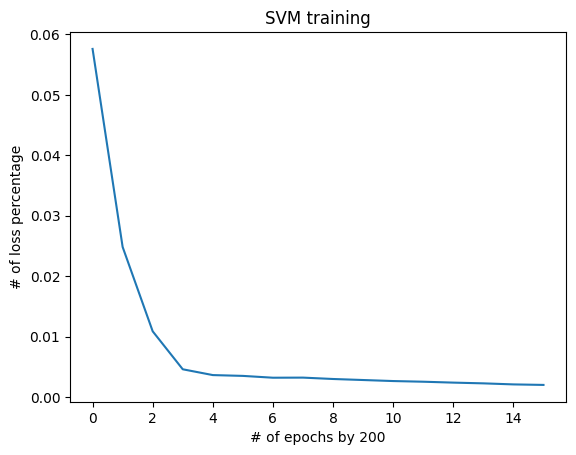

In [ ]:
plt.title('SVM training')
plt.xlabel('# of epochs by 200')
plt.ylabel('# of loss percentage')
plt.plot(losses)

In [ ]:
def accuracy(y_hat, y):
    # get the number of card frauds predicted
    pred_fraud = len(np.where(np.ceil(pred) > 0)[0])
    # actual fraud numbers
    actual_fraud = len(np.where(y > 0)[0])

    return pred_fraud/actual_fraud

In [ ]:
accuracy(pred, y)

1.0

<a id="conclusion"></a>
# Conclusion

As we can see, the model created a classifier that detects between fraud and non-fraud for credit cards.<br>
<br>
Please don't forget to like my notebook, it gives me motivation to create quality content.